In [1]:
using Printf
using DelimitedFiles
using Plots
using LinearAlgebra

In [2]:
struct CaseConfig 
    LX::Float64
    LY::Float64
    
    NUM_X_CELLS::Int64
    NUM_Y_CELLS::Int64
    
    NUM_RK_STEPS::Int64

    NUM_TIME_STEPS::Int64
    TIME_STEPS_SIZE::Float64
end

In [8]:
mutable struct Cell
    C_POS::Array{Float64,1}
    W_POS::Array{Float64,1}
    E_POS::Array{Float64,1}
    N_POS::Array{Float64,1}
    S_POS::Array{Float64,1}

    C_VAL::Array{Float64,1} # center value
    W_VAL::Dict{String,Array{Float64,1}} # west face value
    E_VAL::Dict{String,Array{Float64,1}} # east face value
    N_VAL::Dict{String,Array{Float64,1}} # north face value
    S_VAL::Dict{String,Array{Float64,1}} # south faec value

    W_UNINORM::Array{Float64,1}
    E_UNINORM::Array{Float64,1}
    N_UNINORM::Array{Float64,1}
    S_UNINORM::Array{Float64,1}

    TOTAL_FLUX::Array{Float64,1} 
    
    X_SIZE::Float64
    Y_SIZE::Float64

    # ===============================================================================
    # Construct function
    # ===============================================================================
    function Cell(config::CaseConfig, px::Float64, py::Float64, w_d::Float64, e_d::Float64, n_d::Float64, s_d::Float64)
        this = new()
    
            this.C_POS = [px, py]
            this.W_POS = [px-w_d, py]
            this.E_POS = [px+e_d, py]
            this.N_POS = [px, py+n_d]
            this.S_POS = [px, py-s_d]
        

            this.W_UNINORM = [-1.0, 0.0]
            this.E_UNINORM = [ 1.0, 0.0]
            this.N_UNINORM = [0.0,  1.0]
            this.S_UNINORM = [0.0, -1.0]
    
        
            this.C_VAL = zeros(config.NUM_RK_STEPS+1)
    
            this.W_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS+1),
                               "V" => zeros(config.NUM_RK_STEPS+1),
                               "P" => zeros(config.NUM_RK_STEPS+1) )
    
            this.E_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS+1),
                               "V" => zeros(config.NUM_RK_STEPS+1),
                               "P" => zeros(config.NUM_RK_STEPS+1) )
    
            this.N_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS+1),
                               "V" => zeros(config.NUM_RK_STEPS+1),
                               "P" => zeros(config.NUM_RK_STEPS+1) )
    
            this.S_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS+1),
                               "V" => zeros(config.NUM_RK_STEPS+1),
                               "P" => zeros(config.NUM_RK_STEPS+1) )

            
            this.TOTAL_FLUX = zeros(config.NUM_RK_STEPS+1)
            
            this.X_SIZE = w_d + e_d
            this.Y_SIZE = n_d + s_d
    
        return this
    end
end

In [17]:
mutable struct RecMesh2D
    P_CELL::Array{Cell,2}
    U_CELL::Array{Cell,2}
    V_CELL::Array{Cell,2}
    
    # ===============================================================================
    # Construct function
    # ===============================================================================
    function RecMesh2D(config::CaseConfig)
        this = new()
        
        node_x = map(x->compute_streching(x,x)*config.LX, range(0, 1, length=config.NUM_X_CELLS+1))
        node_y = map(x->compute_streching(x,x)*config.LY, range(0, 1, length=config.NUM_Y_CELLS+1))

        push!(node_x, node_x[end]+(node_x[end]-node_x[end-1]))
        pushfirst!(node_x, node_x[1]-(node_x[2]-node_x[1]))
    
        push!(node_y, node_y[end]+(node_y[end]-node_y[end-1]))
        pushfirst!(node_y, node_y[1]-(node_y[2]-node_y[1]))

        
        this.P_CELL = [ Cell(config, 0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_y[j]+node_y[j+1]), 
                                     0.5*(node_x[i]+node_x[i+1])-node_x[i],
                                     node_x[i+1]-0.5*(node_x[i]+node_x[i+1]),
                                     node_y[i+1]-0.5*(node_y[j]+node_y[j+1]),
                                     0.5*(node_y[j]+node_y[j+1])-node_y[i])
            
                        for i = 1 : config.NUM_X_CELLS+2,
                            j = 1 : config.NUM_Y_CELLS+2 ]
        
        
        
        this.U_CELL = [ Cell(config, node_x[i+1],
                                     0.5*(node_y[j]+node_y[j+1]),
                                     node_x[i+1] - 0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_x[i+1]+node_x[i+2]) - node_x[i+1],
                                     node_y[j+1]-0.5*(node_y[j]+node_y[j+1]),
                                     0.5*(node_y[j]+node_y[j+1])-node_y[j])
            
                        for i = 1 : config.NUM_X_CELLS+1,
                            j = 1 : config.NUM_Y_CELLS+2 ]    

        
        this.V_CELL = [ Cell(config, 0.5*(node_x[i]+node_x[i+1]),
                                     node_y[j+1],
                                     0.5*(node_x[i]+node_x[i+1])-node_x[i],
                                     node_x[i+1]-0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_y[j+1]+node_y[j+2]) - node_y[j+1],
                                     node_y[j+1] - 0.5*(node_y[j]+node_y[j+1]))
            
                        for i = 1 : config.NUM_X_CELLS+2,
                            j = 1 : config.NUM_Y_CELLS+1 ]
        
        #         sz_x = map(i-> this.P_CELL[i+1,1].C_POS[1]-this.P_CELL[i,1].C_POS[1], range(1, config.NUM_X_CELLS+1))
#         sz_y = map(i-> 0.5*(cell_fy[i]+cell_fy[i+1]) - 0.5*(cell_fy[i]+cell_fy[i+2]) ,  range(1, config.NUM_Y_CELLS))
       
#         push!(sz_y, sz_y[end]+(sz_y[end]-sz_y[end-1]))
#         pushfirst!(sz_y, sz_y[1]-(sz_y[2]-sz_y[1]))
    
#         this.U_CELL = [ Cell(config, cell_fx[i+1], 0.5*(cell_fx[j]+cell_fx[j+1]), sz_x[i], sz_y[j])
#                         for i = 1 : config.NUM_X_CELLS+1,
#                             j = 1 : config.NUM_Y_CELLS+2 ]


#         sz_x = map(i-> 0.5*(cell_fx[i]+cell_fx[i+1]) - 0.5*(cell_fx[i]+cell_fx[i+2]), range(1, config.NUM_X_CELLS))
#         sz_y = map(i-> this.P_CELL[1,i+1].C_POS[2]-this.P_CELL[1,i].C_POS[2] ,  range(1, config.NUM_Y_CELLS+1))
    
#         push!(sz_x, sz_x[end]+(sz_x[end]-sz_x[end-1]))
#         pushfirst!(sz_x, sz_x[1]-(sz_x[2]-sz_x[1]))
    
#         this.V_CELL = [ Cell(config, 0.5*(cell_fx[i]+cell_fx[i+1]), cell_fy[j+1], sz_x[i], sz_y[j])
#                         for i = 1 : config.NUM_X_CELLS+2,
#                             j = 1 : config.NUM_Y_CELLS+1 ]
    
        return this
    end


    # ===============================================================================
    # Compute Strech fun by Newton method
    # ===============================================================================
    function compute_streching(x0::Float64, xn::Float64, K::Float64 =1.5, Beta::Float64 = 0.5,
                               e::Float64 = 0.001, iter_max::Int64 = 50)

        x_a = x0

        subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
        subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

        x_b = x_a-subs/subs_x
        iter_num=1

        while abs(x_a-x_b)>e
            iter_num = iter_num+1
            x_a = x_b
            subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
            subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

            x_b = x_a-subs/subs_x

            if iter_num>=iter_max
                return x_b
            end
        end

        return x_b
    end
    
end

In [19]:

myconfig = CaseConfig(1, 1, 10, 10, 1, 10, 0.01)
mymesh = RecMesh2D(myconfig)

println("r")
# function linear_interpolate(cell_1, cell_2)
    
#     p1_len = LinearAlgebra.norm(cell_1.C_POS - target_Cell[i,j].CENTER_POS)
#     p2_len = LinearAlgebra.norm(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS)

#     total_len =  p1_len + p2_len
 
#     return (p1_len*cell_2.C_VAL + p2_len*cell_1.C_VAL) / total_len
    
# end

# function cal_face_val(myconfig::CaseConfig, mymesh::RecMesh2D)
    
#     for rk_step = 1 : myconfig.NUM_RK_STEPS + 1
        
#         # CELL_P
#         for i = 2 : size(mymesh.P_CELL,1)-1
#             for j = 2 : size(mymesh.P_CELL,2)-1

#                 mymesh.P_CELL[i,j].W_VAL["P"][rk_step] = linear_interpolate(mymesh.P_CELL[i-1,j],mymesh.P_CELL[i,j])

#             end
#         end
        
        
        
#     end
# end

# cal_face_val(myconfig, mymesh)

r


In [19]:
function linear_weight(target::String, source::String, i::Int64, j::Int64, mesh::RecMesh2D)
    
    if  target == "U"
        target_Cell = mesh.U_CELL
    elseif target == "V"
        target_Cell = mesh.V_CELL
    elseif target == "P"
        target_Cell = mesh.P_CELL
    else
        @assert false "target not defined"
    end
    
    
    if  source == "U"
        source_Cell = mesh.U_CELL
    elseif source == "V"
        source_Cell = mesh.V_CELL
    elseif source == "P"
        source_Cell = mesh.P_CELL
    else
        @assert false "source not defined"
    end
    
    
    if target =="P" && source =="U"
        p1_len = LinearAlgebra.norm(source_Cell[i-1,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        p2_len = LinearAlgebra.norm(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        
        total_len =  p1_len + p2_len

        result = (p1_len*source_Cell[i,j].VAL + p2_len*source_Cell[i-1,j].VAL)/total_len
        
    elseif target =="P" && source =="V"
        p1_len = LinearAlgebra.norm(source_Cell[i,j-1].CENTER_POS - target_Cell[i,j].CENTER_POS)
        p2_len = LinearAlgebra.norm(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        
        total_len =  p1_len + p2_len

        result = (p1_len*source_Cell[i,j].VAL + p2_len*source_Cell[i,j-1].VAL)/total_len
        
    elseif target =="U" && source =="P"
        p1_len = LinearAlgebra.norm(source_Cell[i+1,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        p2_len = LinearAlgebra.norm(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        
        total_len =  p1_len + p2_len

        result = (p1_len*source_Cell[i,j].VAL + p2_len*source_Cell[i+1,j].VAL)/total_len  
        
    elseif target =="V" && source =="P"
        p1_len = LinearAlgebra.norm(source_Cell[i,j+1].CENTER_POS - target_Cell[i,j].CENTER_POS)
        p2_len = LinearAlgebra.norm(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS)
        
        total_len =  p1_len + p2_len

        result = (p1_len*source_Cell[i,j].VAL + p2_len*source_Cell[i,j+1].VAL)/total_len  
        
    elseif target =="U" && source =="V"
        #https://en.wikipedia.org/wiki/Bilinear_interpolation
        p1_area = abs(prod(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS))
        p2_area = abs(prod(source_Cell[i+1,j].CENTER_POS - target_Cell[i,j].CENTER_POS))  
        p3_area = abs(prod(source_Cell[i+1,j-1].CENTER_POS - target_Cell[i,j].CENTER_POS))
        p4_area = abs(prod(source_Cell[i,j-1].CENTER_POS - target_Cell[i,j].CENTER_POS))
        
        result = ( p1_area*source_Cell[i+1,j-1].VAL + p2_area*source_Cell[i,j-1].VAL +
                   p3_area*source_Cell[i,j].VAL + p4_area*source_Cell[i+1,j].VAL)
        
    elseif target =="V" && source =="U"
        #https://en.wikipedia.org/wiki/Bilinear_interpolation
        p1_area = abs(prod(source_Cell[i-1,j+1].CENTER_POS - target_Cell[i,j].CENTER_POS))
        p2_area = abs(prod(source_Cell[i,j+1].CENTER_POS - target_Cell[i,j].CENTER_POS))  
        p3_area = abs(prod(source_Cell[i,j].CENTER_POS - target_Cell[i,j].CENTER_POS))
        p4_area = abs(prod(source_Cell[i-1,j].CENTER_POS - target_Cell[i,j].CENTER_POS))
        
        result = ( p1_area*source_Cell[i,j].VAL + p2_area*source_Cell[i-1,j].VAL +
                   p3_area*source_Cell[i-1,j+1].VAL + p4_area*source_Cell[i,j+1].VAL)   
    elseif target == source
        
        result = source_Cell[i,j].VAL
        
    end

    
    return result
end


linear_weight (generic function with 1 method)

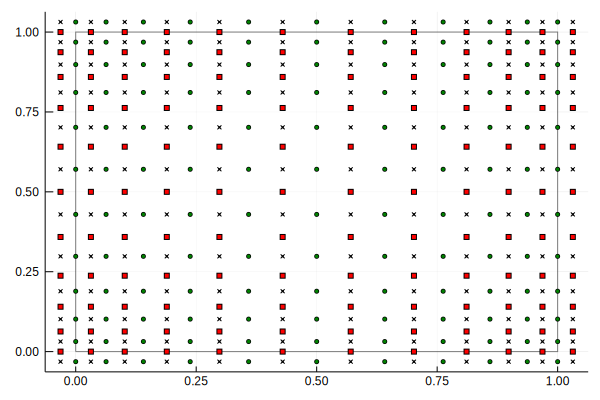

In [21]:
myconfig = CaseConfig(1, 1, 10, 10, 1, 10, 0.01)
mymesh = RecMesh2D(myconfig)


CELLPx = [ mymesh.P_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]

CELLPy = [ mymesh.P_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]


CELLUx = [ mymesh.U_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+1,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]

CELLUy = [ mymesh.U_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+1,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]


CELLVx = [ mymesh.V_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+1 ]

CELLVy = [ mymesh.V_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+1 ]

plot(Shape( [0,1,1,0],  [0,0,1,1]), fillcolor = :white, opacity=.5)
scatter!(collect(Iterators.flatten(CELLPx)), collect(Iterators.flatten(CELLPy)), markershape = :xcross, markersize = 1, markercolor = :black, leg=false)
scatter!(collect(Iterators.flatten(CELLUx)), collect(Iterators.flatten(CELLUy)), markershape = :circle, markersize = 2, markercolor = :green, leg=false)
scatter!(collect(Iterators.flatten(CELLVx)), collect(Iterators.flatten(CELLVy)), markershape = :rect, markersize = 2, markercolor = :red, leg=false)

## Adection Operation

In [15]:
for i = 2 : myconfig.NUM_X_CELLS
    for j = 2 : myconfig.NUM_Y_CELLS+1
        
        vol = mymesh.U_CELL[i,j].SZ_X*mymesh.U_CELL[i,j].SZ_Y
        (linear_weight("P","U", i+1, j, mymesh)^2 - linear_weight("P","U", i, j, mymesh)^2)**mymesh.U_CELL[i,j].SZ_Y
        (linear_weight("P","U", i+1, j, mymesh)*linear_weight("P","V", i+1, j, mymesh))
        
        ( (mymesh.U_CELL[i+1,j].VAL + mymesh.U_CELL[i,j].VAL)^2 - (mymesh.U_CELL[i,j].VAL + mymesh.U_CELL[i-1,j].VAL)^2 )
    end
end

In [ ]:
(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
   u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)

In [ ]:
for i in range(1,nx):
    for j in range(1,ny+1):
        ut[i,j]=u[i,j]+dt*(-0.25*(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
            u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                        
                        
            v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)+\
            m0/(0.5*(r[i+1,j]+r[i,j]))*((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2+\
            (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2 )+gx)